<div style="text-align:center;font-size:30px;margin:5px;font-weight: bold ">
Ondezoek verband pubs en ongevallen in Engeland
</div>

In [1]:
import sys
import findspark
import pyspark
import folium
import math
import functools
import numpy as np
WhoIsWorking="Atif"
if(WhoIsWorking=="Daan"):
    findspark.init("c:/Users/Eigenaar/spark-3.1.2-bin-hadoop3.2")
else:
    findspark.init("C:\\spark-3.1.2-bin-hadoop3.2\\spark-3.1.2-bin-hadoop3.2")

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import avg
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from pyspark.sql.functions import col
from collections import Counter
from pyspark.sql.functions import count
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import datetime
from pyspark.sql.functions import when
from pyspark.sql.functions import year, month, substring
from selenium import webdriver
from selenium.common.exceptions import WebDriverException
from pathlib import Path

In [3]:
spark = SparkSession.builder.getOrCreate()

# 1. Inleiding

In dit onderzoek zal worden getracht om een verband te zoeken tussen de locaties van pubs en de locaties van accidenten in het Verenigd Koninkrijk.
De gebruikte accidenten en casualties data komen beide van Kaggle: https://www.kaggle.com/benoit72/uk-accidents-10-years-history-with-many-variables . De dataset van de pubs komt ook van Kaggle. Verder wordt er, tijdens het onderzoek, ook gebruik gemaakt van datasets over bijvoorbeeld alcohol  blaastesten die werden genomen na een accident. Deze datasets zijn terug te vinden op https://www.gov.uk/government/statistical-data-sets/reported-drinking-and-driving-ras51 


# 2. Data exploratie

## 2.1 Data importeren
pubs data, accidenten data en casualties data importeren

In [4]:
#Creating schema's
schema_pubs = StructType([
    StructField("Food Standard Agency's ID", StringType(), nullable=True),
    StructField("name", StringType(), nullable=True),
    StructField("address", StringType(), nullable=True),
    StructField("postcode", StringType(), nullable=True),
    StructField("easting", DoubleType(), nullable=True),
    StructField("northing", DoubleType(), nullable=True),
    StructField("latitude", DoubleType(), nullable=False),
    StructField("longitude", DoubleType(), nullable=False),
    StructField("local_authority", StringType(), nullable=True)

])

In [5]:
# importing data 
### casualtiesData_df geeft meer info over het slachtoffer
if(WhoIsWorking=="Daan"):
    casualtiesData_df = spark.read.format('csv').option('header', True).load('Kaggle_datasets/Casualties0514.csv')
    accidentData_df = spark.read.format('csv').option('header',True).load('Kaggle_datasets/Accidents0514.csv')
    pubsData_df = spark.read.format('csv').option('header',False).schema(schema_pubs).load('open_pubs.csv')
else:
    accidentData_df = spark.read.format('csv').option('header',True).load('../../../Desktop/Data mining/Accidents0514.csv')
    pubsData_df = spark.read.format('csv').option('header',False).schema(schema_pubs).load('open_pubs.csv')
    casualtiesData_df = spark.read.format('csv').option('header', True).load('../../../Desktop/Data mining/Casualties0514.csv')

Records met lege values eruit halen. Hier worden ook kolommen gedropt die volgens ons weing zullen bijdragen tot het onderzoek of waarmee wij geen belangrijke diagram mee kunnen maken. 

In [6]:
### Filter de pub data set
counterRowsBeforePubs=pubsData_df.count()
pubsData_df=pubsData_df.dropna(subset=["latitude","longitude"])
print(counterRowsBeforePubs-pubsData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")
### nutteloze kolommen zoals Pedestrian_Crossing,Special_Condition_at_site, Carriageway_Hazards,  want volgens Kaggle hebben bijna alle records dezelfde data dus veel gaat deze kolom ons niet opleveren alleen maar een langere run time. heb ook Location_Northing_OSGR, Location_Easting_OSGR, Local_Authority_(District), Local_Authority_(Highway)1st_Road_Class, 1st_Road_Number, 2nd_Road_Class, 2nd_Road_Number, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities
accidentData_df = accidentData_df.drop("Pedestrian_Crossing", "Special_Condition_at_site","Local_Authority_(Highway)", "Carriageway_Hazards","Location_Northing_OSGR", "Location_Easting_OSGR", "Local_Authority_(District)", "Local_Authority_(Highway)1st_Road_Class", "1st_Road_Number", "2nd_Road_Class", "2nd_Road_Number", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities")
### In casualtiesData heb ik ook een paar kolommen verwijderd => Pedestian_Location, Pedestrian_Movement, Bus_or_Coach_, Vehicle_Reference, Casualty_Reference, Age_Band_of_Casualty, Pedestrian_Road_Maintenance_Worker, Casualty_Home_Area_Type
casualtiesData_df = casualtiesData_df.drop("Pedestian_Location", "Pedestrian_Movement", "Bus_or_Coach_Passenger", "Vehicle_Reference", "Casualty_Reference", "Age_Band_of_Casualty", "Pedestrian_Road_Maintenance_Worker","Casualty_Home_Area_Type" )


146  rijen zijn verwijderd omdat ze lege waarden hadden.


In [7]:
### Filter de accident data set
counterRowsBeforePubs=accidentData_df.count()
accidentData_df=accidentData_df.na.drop()
print(counterRowsBeforePubs-accidentData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")

### Filter de casaulties data
counterRowsBeforeCasaul=casualtiesData_df.count()
casualtiesData_df=casualtiesData_df.na.drop()
print(counterRowsBeforeCasaul-casualtiesData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")


120599  rijen zijn verwijderd omdat ze lege waarden hadden.
0  rijen zijn verwijderd omdat ze lege waarden hadden.


## 2.2 Data transformatie

Hier worden datadrame van de accidenten en casualties gejoined in één dataframe

In [8]:
### twee dataframes in één dataframe joinen m.b.v. ID(Accident_Index). Beide dataframes hebben evenveel records.
joined = accidentData_df.alias("A").join(casualtiesData_df.alias("B"),col("A.Accident_Index") == col("B.Accident_Index"),"inner").select(col("A.Accident_Index"), col("A.Longitude"),col("A.Latitude"), col("A.Police_Force"), col("A.Accident_Severity"), col("A.Number_of_Vehicles"), col("A.Number_of_Casualties"), col("A.Date"), col("A.Day_of_Week"),col("A.Time"), col("A.1st_Road_Class"), col("A.Road_Type"), col("A.Speed_limit"), col("A.Junction_Detail"), col("A.Junction_Control"), col("A.Light_Conditions"), col("A.Weather_Conditions"), col("A.Road_Surface_Conditions"), col("A.Special_Conditions_at_Site"), col("A.Urban_or_Rural_Area"), col("A.Did_Police_Officer_Attend_Scene_of_Accident"), col("A.LSOA_of_Accident_Location"), col("B.Casualty_Class"), col("B.Sex_of_Casualty"), col("B.Age_of_Casualty"), col("B.Casualty_Severity"), col("B.Pedestrian_Location"), col("B.Car_Passenger"), col("B.Casualty_Type")).toDF("Accident_Index", "Longitude","Latitude","Police_Force", "Accident_Severity","Number_of_Vehicles", "Number_of_Casualties", "Date", "Day_of_Week","Time","1st_Road_Class", "Road_Type", "Speed_limit","Junction_Detail", "Junction_Control","Light_Conditions", "Weather_Conditions","Road_Surface_Conditions","Special_Conditions_at_Site","Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident", "LSOA_of_Accident_Location","Casualty_Class","Sex_of_Casualty","Age_of_Casualty","Casualty_Severity","Pedestrian_Location","Car_Passenger","Casualty_Type")

### 2.2.1 Leeftijd categoriseren en nieuwe kolommen toevoegen

Omdat de leeftijd werd meegegeven, kunnen wij later tijdens het visualiseren van onze data heel interessante grafieken plotten op basis van de leeftijd. Wij moeten natuurlijk eerst de leeftijden categoriseren. De leeftijdsgroepen die wij hebben gekozen zijn [16-19], [20-24], [25-29], [30-34], [35-39], [40-49], [50-59], [60-69] en [+70] omdat de datasets van https://www.gov.uk/government/statistical-data-sets/reported-drinking-and-driving-ras51 ook deze leeftijdsgroepen gebruiken.

Verder zullen ook kolommen 'Maand' en 'Jaar' worden toegevoegd aan onze dataframe zodat wij hiermee bijvoorbeeld tijdens het visualiseren van de data kunnen filteren op tijd.

In [9]:
joined = joined.withColumn("Age_of_Casualty", col("Age_of_Casualty").cast("int"))
def sort_age(age):
    age = int(age)
    if 16 <= age < 20:
        return "1"
    elif 20 <= age < 25:
        return "2"
    elif 25<=age <30:
        return "3"
    elif 30<= age <35:
        return "4"
    elif 35<= age <40:
        return "5"
    elif 40<= age <50:
        return "6"
    elif 50 <= age <60 :
        return "7"
    elif 60 <= age <70:
        return "8"
    elif age <= 70:
        return "9"
    else:
        return "10"

def get_jaar(datum):
    return(datum[-4:]) 
def get_maand(datum):
    return(datum[3:5])

joined = joined.withColumn("Age_of_Casualty", col("Age_of_Casualty").cast("int"))
joined = joined.withColumn("Date", col("Date").cast("String"))
joined = joined.withColumnRenamed("1st_Road_Class", "First_Road_Class")
joined2 = joined.rdd.map(lambda x: (x.Accident_Index, x.Longitude, 
                                    x.Latitude, x.Police_Force, x.Accident_Severity, x.Number_of_Vehicles, 
                                    x.Number_of_Casualties, x.Date, x.Day_of_Week, x.Time, x.First_Road_Class, 
                                    x.Road_Type, x.Speed_limit, x.Junction_Detail, x.Junction_Control, x.Light_Conditions, 
                                    x.Weather_Conditions,
                                    x.Road_Surface_Conditions, x.Special_Conditions_at_Site,
                                    x.Urban_or_Rural_Area, x.Did_Police_Officer_Attend_Scene_of_Accident, x.LSOA_of_Accident_Location, x.Casualty_Class, x.Sex_of_Casualty, x.Age_of_Casualty, x.Casualty_Severity, x.Pedestrian_Location, x.Car_Passenger, x.Casualty_Type, sort_age(x.Age_of_Casualty), get_jaar(x.Date), get_maand(x.Date)))

joined2 = joined2.toDF(["Accident_Index", "Longitude" , "Latitude" , "Police_Force" , "Accident_Severity" ,
       "Number_of_Vehicles" , "Number_of_Casualties" , "Date" , "Day_of_Week" , "Time" , "1st_Road_Class" , "Road_Type" , "Speed_limit" , "Junction_Detail" , "Junction_Control" , "Light_Conditions" , "Weather_Conditions" , "Road_Surface_Conditions" , "Special_Conditions_at_Site" , "Urban_or_Rural_Area" ,
       "Did_Police_Officer_Attend_Scene_of_Accident" , "LSOA_of_Accident_Location" , "Casualty_Class" , "Sex_of_Casualty" , 
       "Age_of_Casualty" , "Casualty_Severity" , "Pedestrian_Location" , "Car_Passenger" , "Casualty_Type" , "Age_Cat", "Jaar", "Maand"])

In [ ]:
joined2.groupby("Casualty_Class").count().show()

### 2.2.2 Casualty_Class

De kolom "Casualty_Class" kan waarde "1", "2" of "3" aannemen. Deze waarden geven aan wat de rol, van de persoon in kwestie, was tijdens het accident. 1 = "Driver or rider", 2 = "Passenger", 3 = "Pedestrian". Passagiers kunnen heel moeilijk de oorzaak zijn van een accident en daarom verwijderen wij alle passagiers uit onze dataframe. Dit zal later tijdens het visualiseren van onze data ook voor een minder lange run time zorgen.

In [10]:
joined2 = joined2.where(col("Casualty_Class") != 2)

In [ ]:
joined2.groupby("Age_of_Casualty").count().show(5)

### 2.2.3 Leeftijd

Aangezien wij opzoek zijn naar accidenten die werden veroorzaakt door mensen onder invloed van alcohol, lijkt het ons logisch dat wij de records van kinderen onder de 16 uit onze dataframe halen. De datesets die wij hebben gevonden op https://www.gov.uk/government/statistical-data-sets/reported-drinking-and-driving-ras51 , gaan ook enkel over mensen die ouder zijn dan 16. Dus een extra reden om kinderen uit onze dataframe te halen.

In [11]:
joined2 = joined2.where(col("Age_of_Casualty") >= 16)

In [ ]:
joined2.groupby("Casualty_Type").count().show(20)

### 2.2.4 Causualty_Type

De datasets die wij hebben gevonden op https://www.gov.uk/government/statistical-data-sets/reported-drinking-and-driving-ras51 gaan elke over voetgangers, motorfietsen en autos. In onze dataframe zijn er ook andere voertuigen aanwezig zoals 10-tonners, paarden, trammen en nog veel andere vervoersmiddelen die niet in onze dataframe horen. Deze halen wij er dus uit.

In [12]:
joined2 = joined2.where(col("Casualty_Type") != 8)
joined2 = joined2.where(col("Casualty_Type") != 10)
joined2 = joined2.where(col("Casualty_Type") != 11)
joined2 = joined2.where(col("Casualty_Type") != 16)
joined2 = joined2.where(col("Casualty_Type") != 17)
joined2 = joined2.where(col("Casualty_Type") != 18)
joined2 = joined2.where(col("Casualty_Type") != 19)
joined2 = joined2.where(col("Casualty_Type") != 20)
joined2 = joined2.where(col("Casualty_Type") != 21)
joined2 = joined2.where(col("Casualty_Type") != 23)
joined2 = joined2.where(col("Casualty_Type") != 90)
joined2 = joined2.where(col("Casualty_Type") != 97)
joined2 = joined2.where(col("Casualty_Type") != 98)

In het visualisatie gedeelte zouden wij graag interactieve maps willen maken, maar met grote datasets als deze zal het laden te lang duren. Als wij naar  RAS51004  kijken dan zien wij hoeveel % van alle accidenten per leeftijdscategorie er werd veroorzaakt door alcohol.

In [229]:
sqlContext = SQLContext(spark)#Running Query
joined2.createOrReplaceTempView("joined2")
een = sqlContext.sql("SELECT * FROM joined2 WHERE Age_Cat=1")
eenselect = een.select('Accident_Index').distinct().sample(withReplacement=True, fraction= 0.035)
eenjoin  = eenselect.join(een, on='Accident_Index', how='left')
twee = sqlContext.sql("SELECT * FROM joined2 WHERE Age_Cat=2")
tweeselect = twee.select('Accident_Index').distinct().sample(withReplacement=True, fraction= 0.035)
tweejoin  = tweeselect.join(twee, on='Accident_Index', how='left')
drie= sqlContext.sql("SELECT * FROM joined2 WHERE Age_Cat=3")
drieselect = drie.select('Accident_Index').distinct().sample(withReplacement=True, fraction= 0.035)
driejoin  = drieselect.join(drie, on='Accident_Index', how='left')
vier= sqlContext.sql("SELECT * FROM joined2 WHERE Age_Cat=4")
vierselect = vier.select('Accident_Index').distinct().sample(withReplacement=True, fraction= 0.032)
vierjoin  = vierselect.join(vier, on='Accident_Index', how='left')
vijf = sqlContext.sql("SELECT * FROM joined2 WHERE Age_Cat=5")
vijfselect = vijf.select('Accident_Index').distinct().sample(withReplacement=True, fraction= 0.03)
vijfjoin = vijfselect.join(vijf, on='Accident_Index', how='left')
zes = sqlContext.sql("SELECT * FROM joined2 WHERE Age_Cat=6")
zesselect = zes.select('Accident_Index').distinct().sample(withReplacement=True, fraction= 0.02)
zesjoin  = zesselect.join(zes, on='Accident_Index', how='left')
zeven = sqlContext.sql("SELECT * FROM joined2 WHERE Age_Cat=7")
zevenselect = zeven.select('Accident_Index').distinct().sample(withReplacement=True, fraction= 0.018)
zevenjoin = zevenselect.join(zeven, on='Accident_Index', how='left')
acht = sqlContext.sql("SELECT * FROM joined2 WHERE Age_Cat=8")
achtselect = acht.select('Accident_Index').distinct().sample(withReplacement=True, fraction= 0.01)
achtjoin  = achtselect.join(acht, on='Accident_Index', how='left')
negen = sqlContext.sql("SELECT * FROM joined2 WHERE Age_Cat=9")
negenselect = negen.select('Accident_Index').distinct().sample(withReplacement=True, fraction= 0.008)
negenjoin = negenselect.join(negen, on='Accident_Index', how='left')
join3 = eenjoin.union(tweejoin)
join3 = join3.union(driejoin)
join3 = join3.union(vierjoin)
join3 = join3.union(vijfjoin)
join3 = join3.union(zesjoin)
join3 = join3.union(zevenjoin)
join3 = join3.union(achtjoin)
join3 = join3.union(negenjoin)


In [13]:
acc_alc = spark.read.format('csv').option('header',True).load('accident_alcohol.csv').toDF("Accident_Index", "Longitude" , "Latitude" , "Police_Force" , "Accident_Severity" ,
       "Number_of_Vehicles" , "Number_of_Casualties" , "Date" , "Day_of_Week" , "Time" , "1st_Road_Class" , "Road_Type" , "Speed_limit" , "Junction_Detail" , "Junction_Control" , "Light_Conditions" , "Weather_Conditions" , "Road_Surface_Conditions" , "Special_Conditions_at_Site" , "Urban_or_Rural_Area" ,
       "Did_Police_Officer_Attend_Scene_of_Accident" , "LSOA_of_Accident_Location" , "Casualty_Class" , "Sex_of_Casualty" , 
       "Age_of_Casualty" , "Casualty_Severity" , "Pedestrian_Location" , "Car_Passenger" , "Casualty_Type" , "Age_Cat", "Jaar", "Maand")

# 3. Data visualiseren

In dit deel van het onderzoek zal de data worden gevisualiseerd door betekenisvolle diagrammen en interactieve maps.

## 3.1 Accidenten pubs en alcoholfactoren

### 3.1.1 Heatmap hoeveelheid accidenten bij cafe's

In [14]:
#Creating Table
pubsData_df.registerTempTable('pubsTable')
accidentData_df.registerTempTable('accidentTable')
joined2.registerTempTable('joined2')
casualtiesData_df.registerTempTable('casualtiesTable')
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)#Running Query
#Running Query
df1 = sqlContext.sql("SELECT COUNT(local_authority) as count,local_authority from pubsTable group by local_authority order by count")
df2 = sqlContext.sql("SELECT COUNT(Number_of_Casualties) as count_casulties,SPEED_LIMIT FROM joined2 group by SPEED_LIMIT order by SPEED_LIMIT")
## type sql dataframe .collect to get list
local_authority=[]
for row in df1.orderBy("local_authority").collect():
    local_authority.append(row.local_authority)

choose_local_authority = widgets.Dropdown(
    options=local_authority,
    value='Isles of Scilly',
    description='Authority:',
)

def load_map_points(local_authority):
    df1 = sqlContext.sql("SELECT * from pubsTable where local_authority='"+local_authority+"'")
   
    maxLat=str(df1.agg({"latitude": "max"}).collect()[0][0])
    minLat=str(df1.agg({"latitude": "min"}).collect()[0][0])
    maxLot=str(df1.agg({"longitude": "max"}).collect()[0][0])
    minLot=str(df1.agg({"longitude": "min"}).collect()[0][0])
    
    #LatLong = sqlContext.sql("Select CAST(SUBSTRING(Latitude,0,4) AS float) as fLatitude, CAST(CASE when SUBSTRING(Longitude,0,1)='-' then SUBSTRING(Longitude,0,5) else SUBSTRING(Longitude,0,4)end AS float) as fLongitude FROM accidentTable")
    LatLong = sqlContext.sql("Select CAST(Latitude AS float) as fLatitude, CAST(Longitude AS float) as fLongitude FROM accidentTable where (Latitude like '%"+minLat[0:3]+"%' or Latitude like '%"+maxLat[0:3]+"%') and (Longitude like '%"+minLot[0:3]+"%' or Longitude like '%"+maxLot[0:3]+"%')")
    df1=df1.collect()
    local_authority_coordinates = (df1[0].latitude,df1[0].longitude)
    map = folium.Map(location=local_authority_coordinates, zoom_start=11.5)
    HeatMap(LatLong.collect()).add_to(map)

    ## testing 
    counter=0
    for row in df1:
        folium.Marker(location = [row.latitude,row.longitude],popup=row.name).add_to(map)
    display(map)
def on_change(change):
    load_map_points(change)
interact(on_change, change=choose_local_authority);

interactive(children=(Dropdown(description='Authority:', index=164, options=('Aberdeen City', 'Aberdeenshire',…

Hierboven zien we een map met alle café's van een geslecteerde lokale overheid (vergelijkbaar met gemeente van België). Met alle accidenten die in de buurt zijn gebeurt van 2005-2014. Je kan bij vele gemeentes zien dat de ongevallen vaaker gebeuren in de buurt van café's maar dat is niet overal. 

### 3.1.2 Interactieve map alcohol oorzaak van accident

In [15]:
severity = widgets.Dropdown(
    options=["1", "2", "3"],
    value='1',
    description='Severity:',
)
jaar = widgets.Dropdown(
    options= ["2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014"],
    value='2012',
    description='Year:',
)
X = widgets.Dropdown(
    options=["1", "2", "3", "4", "5", "6", "7", "8", "9"],
    value='1',
    description='Age group:',
)
month = widgets.Dropdown(
    options=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
    value='01',
    description='Month:',
)

age = ["[16-19]","[20-24]", "[25-29]", "[30-34]", "[35-39]", "[40-49]", "[50-59]", "[60-69]", "[+70]" ]
maand =["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December" ]
sev =["Light Accident", "Hospitalized", "Fatal"]
sqlContext = SQLContext(spark)#Running Query
acc_alc.registerTempTable('acc_alc')
def load_map_acc(severity, jaar, X, month):
    dfa1 = sqlContext.sql("SELECT * FROM acc_alc WHERE Casualty_Severity="+severity+" AND Jaar= "+jaar+" AND Age_Cat= "+X+" AND Maand = "+month + " AND Sex_of_Casualty = 1")
    dfa2 = sqlContext.sql("SELECT * FROM acc_alc WHERE Casualty_Severity="+severity+" AND Jaar= "+jaar+" AND Age_Cat= "+X+" AND Maand = "+month + " AND Sex_of_Casualty = 2")
    coo = (53.5, -1.5)
   
    mapa = folium.Map(location = coo, zoom_start=6)
    for row in dfa1.collect():
        folium.Marker(location= [row.Latitude, row.Longitude],  icon=folium.Icon(color="blue", icon="male", prefix="fa")).add_to(mapa)
    for row in dfa2.collect():
        folium.Marker(location= [row.Latitude, row.Longitude],  icon=folium.Icon(color="pink", icon="female", prefix="fa")).add_to(mapa)
    title_html = '''
                 <h5 align="left" style="font-size:18px"><b>{}</b></h5>
                 '''.format('Accidents due to alcohol for people aged ' +age[int(X)-1] +' in the month '+month+'/'+jaar+' and severity: '+ sev[int(severity)-1]  )
    mapa.get_root().html.add_child(folium.Element(title_html))
    display(mapa)
def on_change(severity, jaar, X, month):
    load_map_acc(severity, jaar, X,month)

interact(on_change,severity=severity, jaar=jaar, X=X, month =month );


interactive(children=(Dropdown(description='Severity:', options=('1', '2', '3'), value='1'), Dropdown(descript…

###  3.1.3 Bars per district

In [ ]:
#Loading map data
##Regions
file = spark.sparkContext.wholeTextFiles("GeoJson/Region_Boundaries.geojson.json")
file=file.collect()[0][1]
Local_Authority_Districts = spark.sparkContext.wholeTextFiles("GeoJson/Local_Authority_Districts_(May_2021)_UK_BFE_V3.geojson")
##Pubs
localPubsCount=pubsData_df.groupby("local_authority").count().collect()
ras51019=spark.read.format('csv').option('header',True).load('Drink_and_drive_datacsv/ras51019.csv')
ras51019 = ras51019.withColumnRenamed("_c0","Region") \
    .withColumnRenamed("Slightly injured (adjusted)3","Total") \
    .withColumnRenamed("Slightly injured (unadjusted)","Slightly injured (adjusted)3") \
    .withColumnRenamed("Killed or seriously injured (adjusted)3","Slightly injured (unadjusted)") \
    .withColumnRenamed("Killed or seriously injured (unadjusted)","Killed or seriously injured (adjusted)3") \
    .withColumnRenamed("Seriously injured (adjusted)3","Killed or seriously injured (unadjusted)") \
    .withColumnRenamed("Seriously injured (unadjusted)","Seriously injured (adjusted)3") \
    .withColumnRenamed("Killed","Seriously injured (unadjusted)") \
    .withColumnRenamed("_c7","Killed") \



ras51019 = ras51019.withColumn("Fatal",col("Fatal").cast(IntegerType())) \
    .withColumn("Serious (unadjusted)",col("Serious (unadjusted)").cast(IntegerType())) \
    .withColumn("Serious (adjusted)3",col("Serious (adjusted)3").cast(IntegerType())) \
    .withColumn("Slight (unadjusted)",col("Slight (unadjusted)").cast(IntegerType())) \
    .withColumn("Slight (adjusted)3",col("Slight (adjusted)3").cast(IntegerType())) \
    .withColumn("Seriously injured (unadjusted)",col("Seriously injured (unadjusted)").cast(IntegerType())) \
    .withColumn("Total26",col("Total26").cast(IntegerType())) \
    .withColumn("Total",col("Total").cast(IntegerType())) \
    .withColumn("Slightly injured (adjusted)3",col("Slightly injured (adjusted)3").cast(IntegerType())) \
    .withColumn("Slightly injured (unadjusted)",col("Slightly injured (unadjusted)").cast(IntegerType())) \
    .withColumn("Killed or seriously injured (adjusted)3",col("Killed or seriously injured (adjusted)3").cast(IntegerType())) \
    .withColumn("Killed or seriously injured (unadjusted)",col("Killed or seriously injured (unadjusted)").cast(IntegerType())) \
    .withColumn("Seriously injured (adjusted)3",col("Seriously injured (adjusted)3").cast(IntegerType())) \
    .withColumn("Killed",col("Killed").cast(IntegerType()))

ras51019=ras51019.drop(col("Total215"))
# creating map
map_hooray = folium.Map(location=[51.5074, 0.1278],
                        zoom_start = 9)

folium.Choropleth(
    geo_data=file,
    name="Total casulties by alchol",
    data=ras51019.select("Region","Total26").collect(),
    columns=["Region","Total26"],
    key_on="feature.properties.name",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Accidents %",
).add_to(map_hooray)
folium.Choropleth(
    geo_data=Local_Authority_Districts.collect()[0][1],
    name="Total bars in local authority",
    data=localPubsCount,
    columns=["local_authority","count"],
    key_on="feature.properties.LAD21NM",
    fill_color="YlGn",
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name="Bars #",
).add_to(map_hooray)
folium.LayerControl().add_to(map_hooray)
display(map_hooray)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 52603)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\atife\anaconda3\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\atife\anaconda3\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\atife\anaconda3\lib\socketserver.py", line 720, in __init__
    self.handle()
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\accumulators.py", line 262, in handle
    poll(accum_updates)
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\accumulators.py", line 235, in poll
    if func():
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\accumulators.py", line 239, in accum_updates
  

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:52544)
Traceback (most recent call last):
  File "C:\Users\atife\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b913d452ec05>", line 53, in <module>
    geo_data=Local_Authority_Districts.collect()[0][1],
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\rdd.py", line 949, in collect
    sock_info = self.ctx._jvm.PythonRDD.collectAndServe(self._jrdd.rdd())
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1304, in __call__
    return_value = get_return_value(
  File "C:\Users\atife\anaconda3\lib\site-packages\pyspark\sql\utils.py", line 111, in deco
    return f(*a, **kw)
  File "C:\Users\atife\anaconda3\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

### 3.1.4 GIF maken

In [211]:
local_authority_coordinates = (52.598, -0.25)

for i in range(2005,2015):
    map = folium.Map(location=local_authority_coordinates, zoom_start=13.5, zoomControl=False)
    df1 = sqlContext.sql("SELECT * from pubsTable where latitude <52.65 and latitude > 52.5 and longitude > -0.27 and longitude < -0.23")
    df1=df1.collect()
    for row in df1:
        folium.Marker(location = [row.latitude,row.longitude], icon=folium.Icon(color="orange", icon="beer", prefix="fa")).add_to(map)
        folium.Circle(location= [row.latitude, row.longitude], radius=500, fill=True, color="orange").add_to(map)
    dfa = sqlContext.sql("SELECT * FROM acc_alc WHERE Jaar ="+str(i)+" and Latitude <52.65 and Latitude > 52.5 and Longitude > -0.27 and Longitude < -0.23")
    for row in dfa.collect():
        folium.Marker(location= [row.Latitude, row.Longitude], icon=folium.Icon(color="black", icon="car", prefix="fa") ).add_to(map)
    title_html = '''
                 <h3 align="left" style="font-size:22px"><b>{}</b></h3>
                 '''.format('Jaar: ' + str(i))   
    map.get_root().html.add_child(folium.Element(title_html))
    map.save('gif/total_perYear_' + str(i) + '.html')

browserHandler = webdriver.Chrome()
for i in range(2005, 2015):
    browserHandler.get(r"gif\total_perYear_"+str(i)+".html")
    browserHandler.get_screenshot_as_file(r"gif\total_perYear_"+str(i)+".png")
image_path = Path()
images = ['gif/total_perYear_2005.png',
 'gif/total_perYear_2006.png',
 'gif/total_perYear_2007.png',
 'gif/total_perYear_2008.png',
 'gif/total_perYear_2009.png',
 'gif/total_perYear_2010.png',
 'gif/total_perYear_2011.png',
 'gif/total_perYear_2012.png',
 'gif/total_perYear_2013.png',
 'gif/total_perYear_2014.png']
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
     
imageio.mimwrite('GifMapp.gif', image_list, fps=1)

## 3.2 Accidenten analyse correlatie met andere factoren

### 3.2.1 Accidenten per snelheidsdrempel

[4, 2, 12024, 824006, 123904, 49916, 231641, 108974]


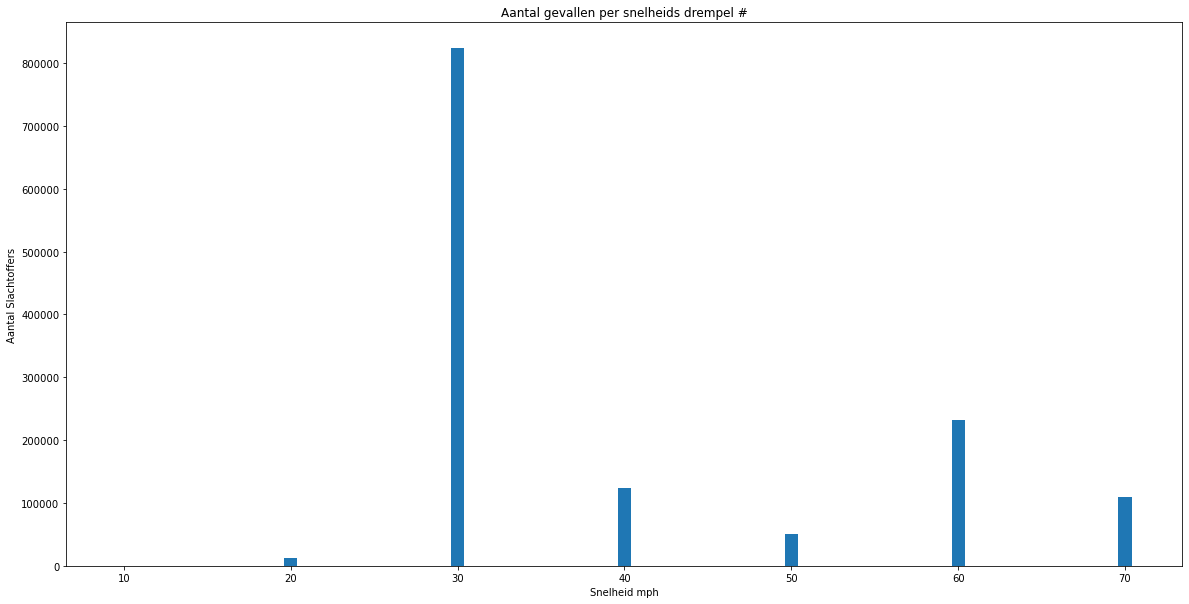

In [20]:
list_casulties_speed=[]
list_speed_casulties=[]
for x in df2.collect():
    list_casulties_speed.append(x[0])
    list_speed_casulties.append(int(x[1]))
print(list_casulties_speed)
plt.bar(list_speed_casulties,list_casulties_speed)
plt.title("Aantal gevallen per snelheids drempel #")
plt.xlabel('Snelheid mph')
plt.ylabel('Aantal Slachtoffers')
plt.show()

Uit het bovenstaande diagram kunnen wij concluderen dat de meeste accindenten gebeuren op wegen waar de maximale toegelaten snelheid 30 mph is, dus vooral binnen de bebouwde kom.

### 3.2.2 Accidenten per leeftijdscategorie

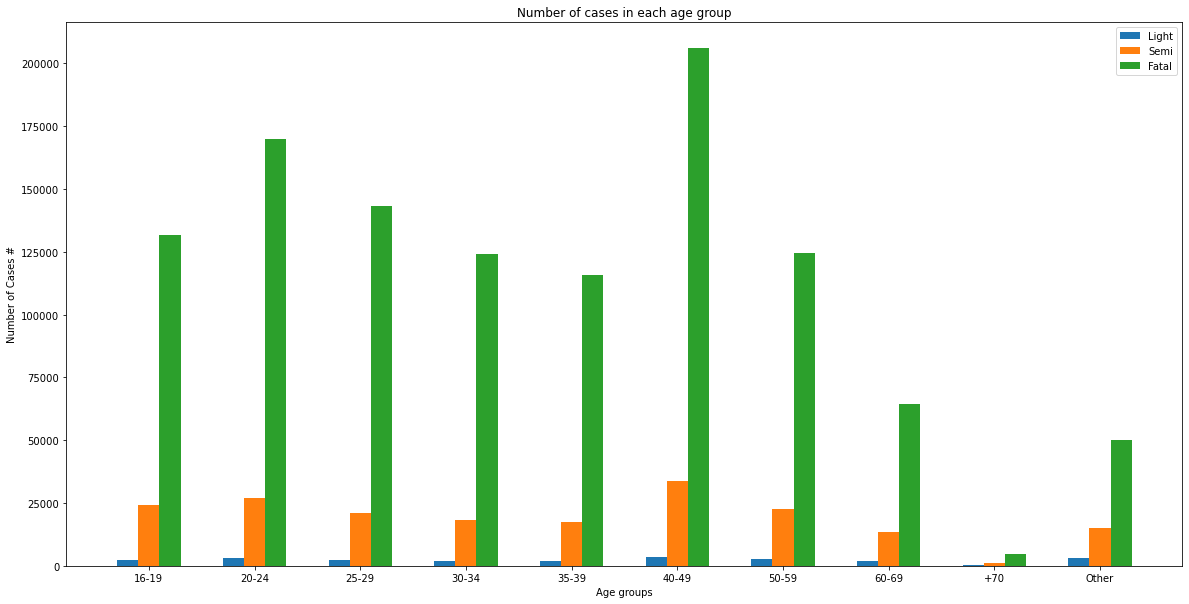

In [21]:
joined2 = joined2.withColumn("Accident_Severity", col("Accident_Severity").cast("int"))
joined2 = joined2.withColumn("Age_Cat", col("Age_Cat").cast("int"))
cat2 = joined2.groupby("Age_Cat", "Accident_Severity").count().toDF("Age_Cat", "Accident_Severity", "count").sort("Age_Cat","Accident_Severity")
X = ["16-19", "20-24", "25-29", "30-34", "35-39", "40-49", "50-59", "60-69", "+70", "Other"]
light = []
semi = []
fatal = []
for x in cat2.collect():
    if x[1] == 1:
        light.append(x[2])
    elif x[1] == 2:
        semi.append(x[2])
    else:
        fatal.append(x[2])
      


X_axis = np.arange(len(X))
plt.bar(X_axis-0.2, light,0.2, label = 'Light')
plt.bar(X_axis, semi,0.2, label = 'Semi')
plt.bar(X_axis+0.2, fatal,0.2, label = 'Fatal')
   
plt.xticks(X_axis, X)
plt.xlabel("Age groups")
plt.ylabel("Number of Cases #")
plt.title("Number of cases in each age group")
plt.legend()
plt.show()

Het bovenstaande diagram geeft het aantal accidenten voor per leeftijdscategorie en per ernstheid van het accident.

### 3.2.3 Kijken naar de accidenten doorheen de tijd

In [18]:
ListOfYears=sqlContext.sql("SELECT Day_of_Week from accidentTable group by Day_of_Week").collect()
Yearslider=widgets.IntSlider(
    min=min(ListOfYears)[0],
    max=max(ListOfYears) [0],
    description='Day:',
)
intresantColoms=("Police_Force","Accident_Severity","Number_of_Vehicles","Number_of_Casualties")
def f(x):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig, axs = plt.subplots(math.ceil((len(intresantColoms)/2)),2)
    fig.suptitle('Het aantal voertuigen, gewonden, ergte en politie aanwezigen per soort voor Dag:'+str(x))
    for indx,onderwerp in enumerate(intresantColoms):
        ListOfDays=sqlContext.sql("SELECT "+onderwerp+",count("+onderwerp+") as aantal from accidentTable where Day_of_Week="+str(x)+" group by "+onderwerp+" order by "+onderwerp).collect()
        NumberList=[]
        BarList=[]
        for row in ListOfDays:
            NumberList.append((row[0]))
            BarList.append(row[1])
        axs[math.ceil(indx/2)-1,indx%2].bar(NumberList,BarList)
        axs[math.ceil(indx/2)-1,indx%2].set_title(onderwerp)
    return x
interact(f, x=Yearslider);

interactive(children=(IntSlider(value=1, description='Day:', max=7, min=1), Output()), _dom_classes=('widget-i…

Hierboven staan enkele diagrammen over de accidenten. Uit het eerste diagram kunnen wij conluderen dat de meeste records een botsing is van twee autos. Het tweede diagram vertelt ons dat de meeste accidenten een waarde 3(fatal) als severity hebben. Het derde diagram vertelt ons meer over welke politie het meest aanwezig waren bij een accident. Hier zien dat waarde 1 ver bovenuit steekt. Waarde 1 is de "Metropolitan Police" of met andere woorden the police force of London. Hieruit kunnen wij dus ook concluderen dat de meeste mensen een auto ongeluk hebben gehad in London. Al deze worden gefilterd op de dagen van de week.

### 3.2.4 Ongevallen per leeftijds categorie van de verongelukte op omgevings factoren

In [23]:
joinAccidentsCasulties = sqlContext.sql('SELECT * from accidentTable right join casualtiesTable on casualtiesTable.Accident_Index==accidentTable.Accident_Index')
ListAccidentsCasulties=joinAccidentsCasulties.select("Age_of_Casualty").distinct().sort("Age_of_Casualty").collect()

Ageslider=widgets.IntSlider(
    min=min(ListAccidentsCasulties)[0],
    max=max(ListAccidentsCasulties)[0],
    description='Age:',
)
intresantColoms=("Light_Conditions","Weather_Conditions","Road_Type","Time","Day_of_Week")

def createArray(dictionary):
    values=[]
    for row in dictionary:
        if not(row[0]==None):
            values.append(row[0])
        else:
            values.append(0)
    return values

def f(x):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig, axs = plt.subplots(3,2)
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[4]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[4]).collect()
    axs[0,0].hist(createArray(colomForGraph),density=False, bins=7)
    axs[0,0].set_title("Hoeveel ongelukken per dag")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[0]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[0]).collect()
    axs[0,1].hist(createArray(colomForGraph))
    axs[0,1].set_title("Hoeveel ongelukken per licht type")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[1]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[1]).collect()
    axs[1,0].hist(createArray(colomForGraph))
    axs[1,0].set_title("Hoeveel ongelukken per weer type")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[2]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[2]).collect()
    axs[1,1].hist(createArray(colomForGraph))
    axs[1,1].set_title("Hoeveel ongelukken per road type")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[3]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[2]).collect()
    axs[2,1].hist(createArray(colomForGraph), bins=24)
    axs[2,1].set_title("Hoeveel ongelukken per dag Uur")
    
    return x
interact(f, x=Ageslider);

interactive(children=(IntSlider(value=0, description='Age:', max=99, min=-1), Output()), _dom_classes=('widget…

Hierboven staan er interactieve diagrammen die worden gefilterd op leeftijd. Zo kunnen wij zien op welke dag er de meeste accidenten gebeuren, bij welke weeromstandigheden, aantal ongelukken per uur en aantal ongelukken per road type.

Interactieve map van alle accidenten die door alcohol zijn veroorzaakt

### 3.2.5 Grafiek accidenten doorheen de tijd

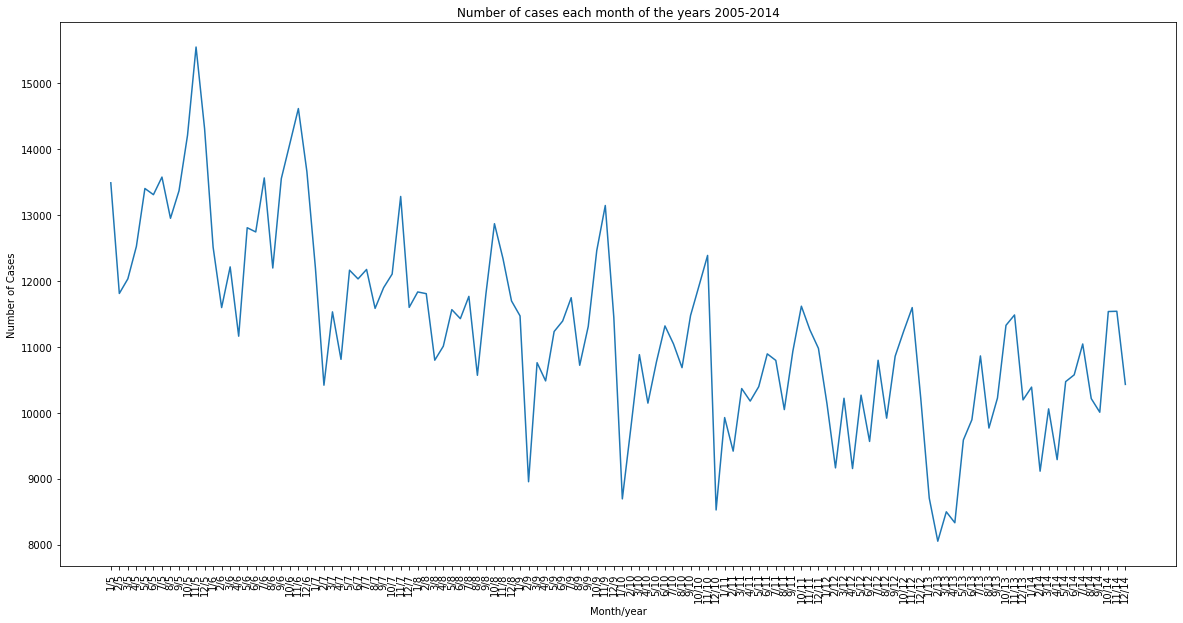

In [22]:
joined2 = joined2.withColumn("Maand", col("maand").cast("int"))
joined2 = joined2.withColumn("Jaar", col("Jaar").cast("int"))
cat2 = joined2.groupby("Jaar", "Maand").count().toDF("Jaar","Maand", "count").sort("Jaar", "Maand")
      
lijst=[]
for x in cat2.collect():
    lijst.append(x[2])

X=[]
for j in range(5,15):
    for i in range(1,13):
        X.append(str(i)+"/"+str(j))

X_axis = np.arange(len(X))
plt.plot(X,lijst)
plt.xlabel("Month/year")
plt.ylabel("Number of Cases")
plt.xticks(rotation=90)
plt.title("Number of cases each month of the years 2005-2014")

plt.show()

# 4. Conclusie

In dit onderzoek zijn we gaan zoeken naar **Verbanden** tussen de **locaties** van pubs en de locatie waar accidenten** plaatsvonden binnen in het **Verenigd Koninkrijk**. We hebben het onderzoek uiteindelijk opgesplitst in twee groten delen: "3.1 Accidenten pubs en alcoholkantoren" & "3.2 Accidenten analyse correlatie met andere factoren", omdat we zagen dat pubs en zelfs alcohol zeker niet als grootste factor uitstaat.

In 3.2 over de **andere factoren** zie je regelmatig grote uitstekende staan die **meer invloed individueel** uitoefen op ongevallen dan de ligging van een pub. Zoals de weg waarop je rijd, hier is de categorie 30 m/h een enorme uitschieter. We kunnen wel speculeren dat het grotendeels van de pubs in druk bevolkte woon kernen ligt waar men maar 30 m/h mag rijden, maar dit gaat niet verder dan speculeren. Ook in 3.2.2 zien we ook een **invloedrijke maatstaf** leeftijd, deze data zegt jammer genoeg niet over alcoholintoxicatie. 3.2.4 toont nog is het vorige puntje mooi aan dat er nog vele andere factoren zijn die te maken hebben met ongelukken zoals: Weekdag, licht omstandigheden, weer omstandigheden, weg type, uur.

We hebben nu juist gezien dat er vele andere factoren zijn naast de locatie van een **café-bar**, maar nu zullen we ook eens kijken naar deze **pijler**. (met in het achterhoofd natuurlijk de andere factoren.). In 3.1.1 zien we wel in de meeste regio's dat **ongevallen** wel vaak in de **buurt** gebeuren van een **café**. 3.1.2 kun je goed het aantal ongevallen zien per maand op de kaart, in 2011 zien we dat er een pak **meer erge ongevallen** gebeuren door dronkenschap in de **feestmaand** tegen over elke andere maand. Maar dit **hangt ook af van elk jaar**, bij 2014 is dit weer niet. Als laatste zullen we 3.1.3 bezien, je kunt hier kijken naar de map met alle **ongevallen per regio en accidenten per district**. In de Cornwall-Gloughstern, orthwest engeland en Midlands east komen de resultaten zeer goed overeen met de verwachtingen maar in de andere regio's een pak minder.

Hieruit kunnen we concluderen dat de **inpakt van een locatie van een café zijn relatief Klein is tegenover andere** factoren zoals: Uur, leeftijd, Zichtbaarheid, ... en dat de ligging van een café een zeer klein verschil maakt.

# 5. Making off

## 5.1 Moelijkheden
- Grote bestanden op github pushen
- Issues op github
- Problemen met gif te maken
- Folium slecht gedocumenteerd
- Elkaars code werkend krijgen. Code van teamgenoot werkt op zijn laptop maar niet bij de andere
- Bij het opzoeken naar informatie om een probleem op te lossen, kregen wij vooral oplossingen met Pandas

## 5.2 Fun things
- Kracht van Spark
- Leren werken met nieuwe software
- Leuke opdracht

## 5.3 Gebruikte technologien
- Spark
- Jupyter Notebook
- Python
- SQL
- Folium
- Pyspark
- Matplotlib
